# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13333137670773379602
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3870186007359001025
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 08:10:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'VGG16'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 3
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2"
T_all_labels = "T0", "T1", "T2"

#base_path = ''
base_path = 'gdrive/My Drive/Research_3_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_VGG16_None S_VGG16_imagenet T_VGG16_None T_VGG16_imagenet


['S_VGG16_imagenet', 'S_VGG16_None', 'T_VGG16_imagenet', 'T_VGG16_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 3)
(480, 128, 128, 3) (480, 3)
(480, 128, 128, 3) (480, 3)

(1920, 128, 128, 3) (1920, 3)
(640, 128, 128, 3) (640, 3)
(640, 128, 128, 3) (640, 3)


## 2-2. Image Check

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


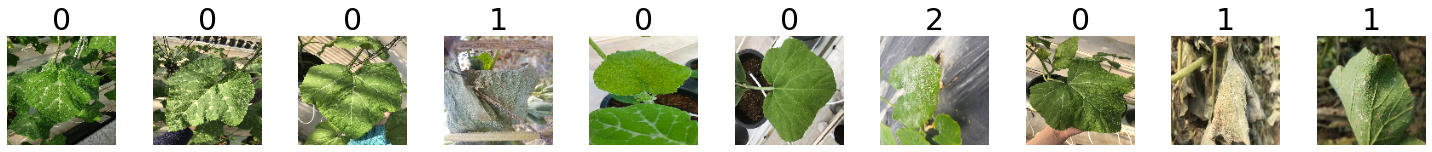

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


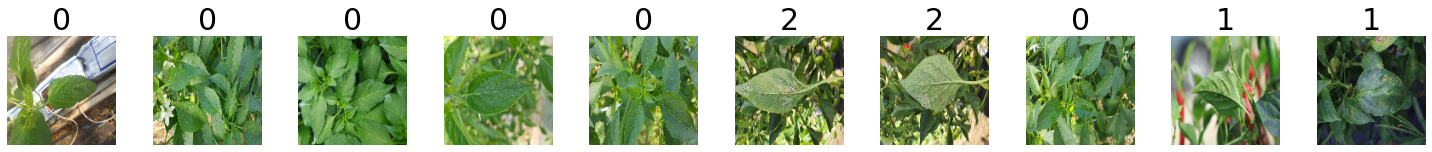

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 17s 245ms/step - loss: 1.1250 - accuracy: 0.4917 - val_loss: 1.0548 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 142ms/step - loss: 1.0414 - accuracy: 0.5000 - val_loss: 1.0406 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 147ms/step - loss: 1.0450 - accuracy: 0.5000 - val_loss: 1.0403 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 144ms/step - loss: 1.0413 - accuracy: 0.5000 - val_loss: 1.0400 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 3s 143ms/step - loss: 1.0427 - accuracy: 0.5000 - val_loss: 1.0398 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 143ms/step - loss: 1.0420 - accuracy: 0.5000 - val_loss: 1.0406 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 3s 143ms/step - loss: 1.0415 - accuracy: 0.5000 - val_loss: 1.0399 - val_accuracy: 0.500

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.124968,0.491667,1.054758,0.5
1,1.041379,0.500000,1.040642,0.5
2,1.045013,0.500000,1.040263,0.5
3,1.041306,0.500000,1.040016,0.5
4,1.042672,0.500000,1.039782,0.5
5,1.041977,0.500000,1.040642,0.5
6,1.041466,0.500000,1.039942,0.5
7,1.040774,0.500000,1.040635,0.5
8,1.041497,0.500000,1.039951,0.5
9,1.040169,0.500000,1.039727,0.5


Minimum validation loss: 1.039703369140625
Maximum validation accuracy: 0.5


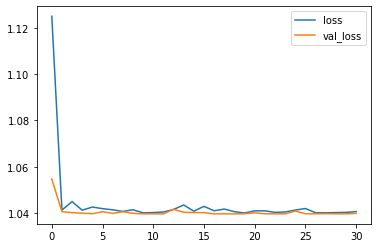

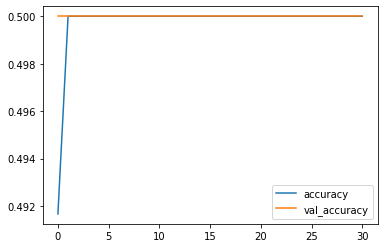

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 23ms/step - loss: 1.0548 - accuracy: 0.5000
test loss, test acc: [1.0547630786895752, 0.5]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

15/15 [==============================] - 0s 20ms/step


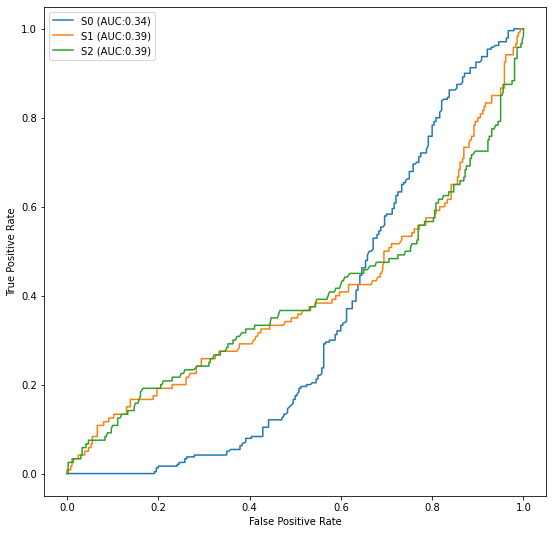

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 4s 158ms/step - loss: 2.8159 - accuracy: 0.4479 - val_loss: 1.0482 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 144ms/step - loss: 1.1392 - accuracy: 0.4507 - val_loss: 1.0679 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 143ms/step - loss: 1.0466 - accuracy: 0.5014 - val_loss: 1.0207 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 146ms/step - loss: 0.9430 - accuracy: 0.5681 - val_loss: 1.1494 - val_accuracy: 0.5271
Epoch 5/100
23/23 [==============================] - 3s 146ms/step - loss: 0.6422 - accuracy: 0.7049 - val_loss: 0.5383 - val_accuracy: 0.7646
Epoch 6/100
23/23 [==============================] - 3s 146ms/step - loss: 0.5175 - accuracy: 0.7715 - val_loss: 0.4969 - val_accuracy: 0.7875
Epoch 7/100
23/23 [==============================] - 3s 144ms/step - loss: 0.4494 - accuracy: 0.8104 - val_loss: 0.5258 - val_accuracy: 0.7688

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,2.815890,0.447917,1.048223,0.500000
1,1.139248,0.450694,1.067919,0.500000
2,1.046630,0.501389,1.020682,0.500000
3,0.942969,0.568056,1.149354,0.527083
4,0.642213,0.704861,0.538329,0.764583
5,0.517478,0.771528,0.496900,0.787500
6,0.449363,0.810417,0.525769,0.768750
7,0.379922,0.838889,0.353043,0.860417
8,0.495738,0.788889,0.432202,0.810417
9,0.471350,0.790972,0.393709,0.847917


Minimum validation loss: 0.045868754386901855
Maximum validation accuracy: 0.9833333492279053


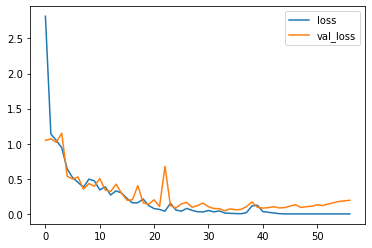

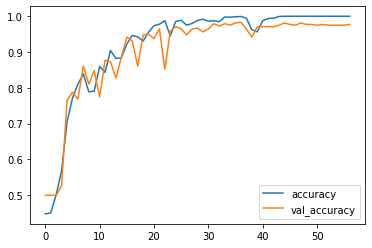

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 22ms/step - loss: 0.1242 - accuracy: 0.9750
test loss, test acc: [0.12416645139455795, 0.9750000238418579]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

15/15 [==============================] - 0s 20ms/step


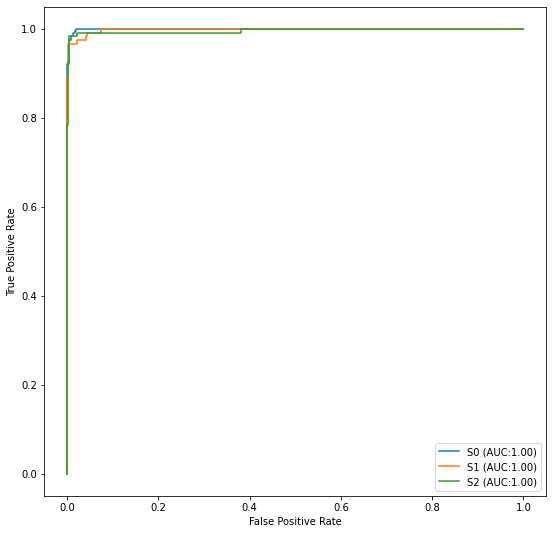

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 6s 158ms/step - loss: 5.5792 - accuracy: 0.4865 - val_loss: 1.0433 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0460 - accuracy: 0.5000 - val_loss: 1.0436 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0444 - accuracy: 0.5000 - val_loss: 1.0402 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0442 - accuracy: 0.5000 - val_loss: 1.0437 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0444 - accuracy: 0.5000 - val_loss: 1.0472 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0423 - accuracy: 0.5000 - val_loss: 1.0403 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0412 - accuracy: 0.5000 - val_loss: 1.0398 - val_accuracy: 0.5000

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,5.579209,0.486458,1.043339,0.5
1,1.045954,0.500000,1.043594,0.5
2,1.044397,0.500000,1.040231,0.5
3,1.044158,0.500000,1.043699,0.5
4,1.044438,0.500000,1.047182,0.5
5,1.042305,0.500000,1.040313,0.5
6,1.041246,0.500000,1.039790,0.5
7,1.041103,0.500000,1.040477,0.5
8,1.040507,0.500000,1.039859,0.5
9,1.041561,0.500000,1.039816,0.5


Minimum validation loss: 1.0397217273712158
Maximum validation accuracy: 0.5


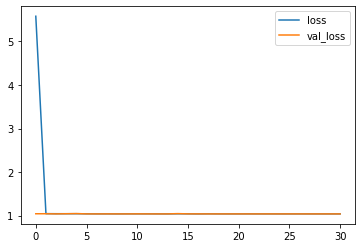

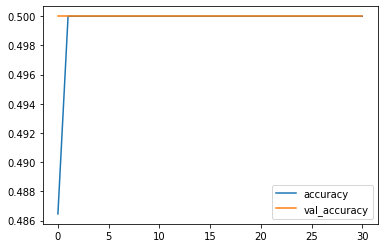

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 1s 22ms/step - loss: 1.0433 - accuracy: 0.5000
test loss, test acc: [1.0433393716812134, 0.5]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 21ms/step


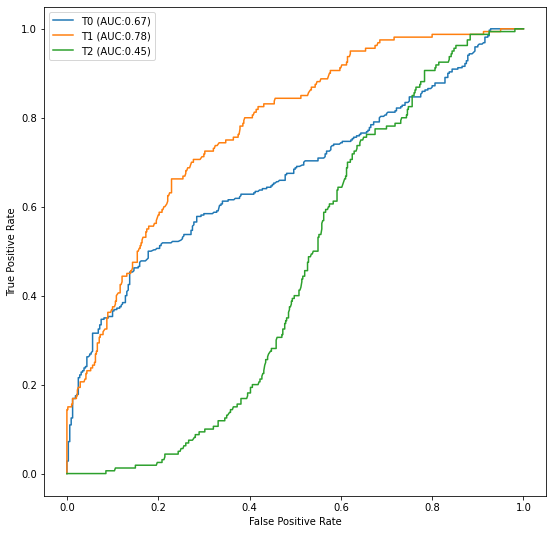

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 5s 156ms/step - loss: 1.2419 - accuracy: 0.4760 - val_loss: 1.0261 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0324 - accuracy: 0.5052 - val_loss: 0.9885 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 4s 146ms/step - loss: 0.9546 - accuracy: 0.5151 - val_loss: 0.8732 - val_accuracy: 0.5734
Epoch 4/100
30/30 [==============================] - 4s 144ms/step - loss: 0.8462 - accuracy: 0.5630 - val_loss: 0.9375 - val_accuracy: 0.5359
Epoch 5/100
30/30 [==============================] - 4s 146ms/step - loss: 0.8781 - accuracy: 0.5724 - val_loss: 0.7443 - val_accuracy: 0.6391
Epoch 6/100
30/30 [==============================] - 4s 144ms/step - loss: 0.7081 - accuracy: 0.6615 - val_loss: 0.7001 - val_accuracy: 0.6203
Epoch 7/100
30/30 [==============================] - 4s 145ms/step - loss: 0.6770 - accuracy: 0.6672 - val_loss: 0.6229 - val_accuracy: 0.7219

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,1.241907,0.476042,1.026116,0.500000
1,1.032369,0.505208,0.988482,0.500000
2,0.954631,0.515104,0.873227,0.573438
3,0.846182,0.563021,0.937481,0.535937
4,0.878138,0.572396,0.744288,0.639063
...,...,...,...,...
75,0.016748,0.993229,0.342223,0.923437
76,0.034430,0.986979,0.348502,0.918750
77,0.068503,0.976562,0.404986,0.907812
78,0.099693,0.965625,0.284285,0.921875


Minimum validation loss: 0.21433746814727783
Maximum validation accuracy: 0.948437511920929


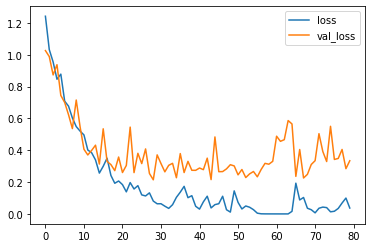

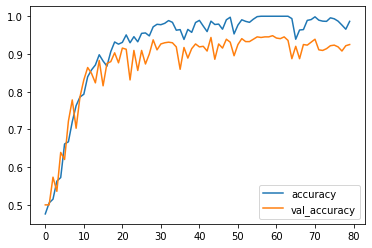

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 1s 24ms/step - loss: 0.2495 - accuracy: 0.9500
test loss, test acc: [0.24947944283485413, 0.949999988079071]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 21ms/step


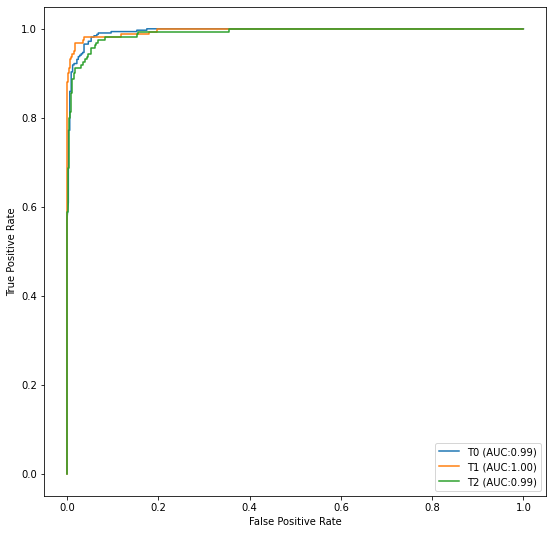

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_VGG16_None
test loss, test acc: [1.0547630786895752, 0.5]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_VGG16_imagenet
test loss, test acc: [0.12416645139455795, 0.9750000238418579]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_VGG16_None
test loss, test acc: [1.0433393716812134, 0.5]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_VGG16_imagenet
test loss, test acc: [0.24947944283485413, 0.949999988079071]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_VGG16_None →→→ Target Test
20/20 [==============================] - 0s 23ms/step - loss: 1.0547 - accuracy: 0.5000
test loss, test acc: [1.0547382831573486, 0.5]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_VGG16_imagenet →→→ Target Test
20/20 [==============================] - 0s 23ms/step - loss: 8.6353 - accuracy: 0.4391
test loss, test acc: [8.635274887084961, 0.4390625059604645]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_VGG16_None →→→ Source Test
15/15 [==============================] - 0s 22ms/step - loss: 1.0434 - accuracy: 0.5000
test loss, test acc: [1.04336678981781, 0.5]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_VGG16_imagenet →→→ Source Test
15/15 [==============================] - 0s 22ms/step - loss: 5.7735 - accuracy: 0.5354
test loss, test acc: [5.773505687713623, 0.5354166626930237]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )